![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/nlu/blob/master/examples/colab/Training/binary_text_classification/NLU_training_sentiment_classifier_demo_apple_twitter.ipynb)



# Training a Sentiment Analysis Classifier with NLU
## 2 class Apple Tweets sentiment classifier training
With the [SentimentDL model](https://nlp.johnsnowlabs.com/docs/en/annotators#sentimentdl-multi-class-sentiment-analysis-annotator) from Spark NLP you can achieve State Of the Art results on any multi class text classification problem

This notebook showcases the following features :

- How to train the deep learning classifier
- How to store a pipeline to disk
- How to load the pipeline from disk (Enables NLU offline mode)

You can achieve these results or even better on this dataset with training data:

<br>

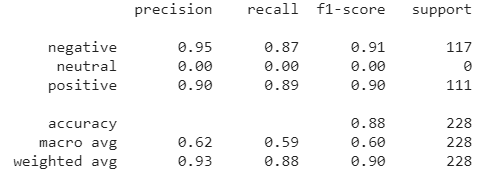

You can achieve these results or even better on this dataset with test data:



<br>


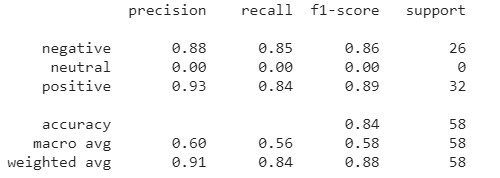



In [ ]:
!pip install -q johnsnowlabs

# 2. Download appple twitter  Sentiment dataset
https://www.kaggle.com/seriousran/appletwittersentimenttexts

this dataset contains tweets made towards apple and today we are going to train our model to predict whether the tweet contains sentiment!


In [ ]:
! wget https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/apple-twitter/apple-twitter-sentiment-texts.csv


In [3]:
import pandas as pd
train_path = '/content/apple-twitter-sentiment-texts.csv'

train_df = pd.read_csv(train_path)
# the text data to use for classification should be in a column named 'text'
# the label column must have name 'y' name be of type str
columns=['text','y']
train_df = train_df[columns]
train_df = train_df[~train_df["y"].isin(["neutral"])]
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_df, test_size=0.2)
train_df

,text,y
44,I'm surprised there isn't more talk about what...,negative
691,over 1 hour on hold with @apple customer servi...,negative
1371,I'm still mad @apple,negative
870,@jokigenki @Apple I think it's like 2011? Can'...,negative
1226,@apple #ios8 The lack of true keyboard integra...,negative
...,...,...
1392,itunes is awful &amp; is ruining my life fix y...,negative
733,Happy Monday! My camera on my fancy @Apple #iP...,negative
503,Phone just died while it was plug in. @apple w...,negative
634,Whoever downgrades from a iphone 6 to a 5S obv...,negative


# 3. Train Deep Learning Classifier using nlu.load('train.sentiment')

You dataset label column should be named 'y' and the feature column with text data should be named 'text'

In [ ]:
from sklearn.metrics import classification_report
from johnsnowlabs import nlp

# load a trainable pipeline by specifying the train. prefix  and fit it on a datset with label and text columns
# by default the Universal Sentence Encoder (USE) Sentence embeddings are used for generation
trainable_pipe = nlp.load('train.sentiment')

fitted_pipe = trainable_pipe.fit(train_df.iloc[:50])

# predict with the trainable pipeline on dataset and get predictions
preds = fitted_pipe.predict(train_df.iloc[:50],output_level='document')
#sentence detector that is part of the pipe generates sone NaNs. lets drop them first
preds.dropna(inplace=True)
print(classification_report(preds['y'], preds['sentiment']))

preds

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
              precision    recall  f1-score   support

    negative       0.82      1.00      0.90        41
    positive       0.00      0.00      0.00         9

    accuracy                           0.82        50
   macro avg       0.41      0.50      0.45        50
weighted avg       0.67      0.82      0.74        50



,document,sentence_embedding_small_bert_L2_128,sentiment,sentiment_confidence,text,y
0,@apple fucking let everyone name the group cha...,"[-1.5767942667007446, -0.2661866843700409, 0.1...",negative,7.0,@apple fucking let everyone name the group cha...,negative
1,"As a die hard @Apple customer, I must say I am...","[-0.1864045411348343, 0.37810075283050537, -0....",negative,5.0,"As a die hard @Apple customer, I must say I am...",negative
2,RT @_iamGambino: Thank you @Apple,"[-0.39863264560699463, -0.018525924533605576, ...",negative,9.0,RT @_iamGambino: Thank you @Apple,positive
3,YO YOU AINT SHIT @apple,"[-1.3272020816802979, -0.6504784226417542, -0....",negative,1.0,YO YOU AINT SHIT @apple,negative
4,Theyre not RT @Naivana_: You gotta be kidding ...,"[-0.26906388998031616, 0.16873443126678467, 0....",negative,3.0,Theyre not RT @Naivana_: You gotta be kidding ...,negative
5,My MacBook Pro is now as annoying as my ASUS W...,"[-0.7138646841049194, -0.03021504543721676, 0....",negative,1.0,My MacBook Pro is now as annoying as my ASUS W...,negative
6,It's just dawned on me that I've probably spen...,"[-0.08956478536128998, -0.09104951471090317, -...",negative,3.0,It's just dawned on me that I've probably spen...,negative
7,Hey @apple @sprint I'm not a fan of your lates...,"[-0.6237524747848511, 0.10997672379016876, 0.6...",negative,3.0,Hey @apple @sprint I'm not a fan of your lates...,negative
8,@apple y'all shitty,"[-1.721300482749939, -1.328816533088684, 0.083...",negative,1.0,@apple y'all shitty,negative
9,YO I DIDNT TOUCH MY PHONE AT ALL AND RIGHT WHE...,"[-0.7379449605941772, 0.2959931790828705, -0.4...",negative,8.0,YO I DIDNT TOUCH MY PHONE AT ALL AND RIGHT WHE...,negative


#4.  Test the fitted pipe on new example

In [ ]:
fitted_pipe.predict('I hate the newest update')

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,sentence,sentence_embedding_small_bert_L2_128,sentiment,sentiment_confidence
0,I hate the newest update,"[-1.3662102222442627, 0.10369864851236343, -0....",negative,1.0


##5.  Configure pipe training parameters

In [ ]:
trainable_pipe.print_info()

The following parameters are configurable for this NLU pipeline (You can copy paste the examples) :
>>> component_list['bert_sentence_embeddings@sent_small_bert_L2_128'] has settable params:
component_list['bert_sentence_embeddings@sent_small_bert_L2_128'].setBatchSize(8)              | Info: Size of every batch | Currently set to : 8
component_list['bert_sentence_embeddings@sent_small_bert_L2_128'].setEngine('tensorflow')      | Info: Deep Learning engine used for this model | Currently set to : tensorflow
component_list['bert_sentence_embeddings@sent_small_bert_L2_128'].setIsLong(False)             | Info: Use Long type instead of Int type for inputs buffer - Some Bert models require Long instead of Int. | Currently set to : False
component_list['bert_sentence_embeddings@sent_small_bert_L2_128'].setMaxSentenceLength(128)    | Info: Max sentence length to process | Currently set to : 128
component_list['bert_sentence_embeddings@sent_small_bert_L2_128'].setDimension(128)            | I

##6.  Retrain with new parameters

In [ ]:
# Train longer!
trainable_pipe = nlp.load('train.sentiment')
trainable_pipe['trainable_sentiment_dl'].setMaxEpochs(5)
fitted_pipe = trainable_pipe.fit(train_df.iloc[:100])
# predict with the trainable pipeline on dataset and get predictions
preds = fitted_pipe.predict(train_df.iloc[:100],output_level='document')

#sentence detector that is part of the pipe generates sone NaNs. lets drop them first
preds.dropna(inplace=True)
print(classification_report(preds['y'], preds['sentiment']))

preds

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
              precision    recall  f1-score   support

    negative       0.82      1.00      0.90        82
    positive       0.00      0.00      0.00        18

    accuracy                           0.82       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.67      0.82      0.74       100



,document,sentence_embedding_small_bert_L2_128,sentiment,sentiment_confidence,text,y
0,@apple fucking let everyone name the group cha...,"[-1.5767942667007446, -0.2661866843700409, 0.1...",negative,1.0,@apple fucking let everyone name the group cha...,negative
1,"As a die hard @Apple customer, I must say I am...","[-0.1864045411348343, 0.37810075283050537, -0....",negative,1.0,"As a die hard @Apple customer, I must say I am...",negative
2,RT @_iamGambino: Thank you @Apple,"[-0.39863264560699463, -0.018525924533605576, ...",negative,1.0,RT @_iamGambino: Thank you @Apple,positive
3,YO YOU AINT SHIT @apple,"[-1.3272020816802979, -0.6504784226417542, -0....",negative,1.0,YO YOU AINT SHIT @apple,negative
4,Theyre not RT @Naivana_: You gotta be kidding ...,"[-0.26906388998031616, 0.16873443126678467, 0....",negative,1.0,Theyre not RT @Naivana_: You gotta be kidding ...,negative
...,...,...,...,...,...,...
95,@Apple you need to sort your phones out.,"[-0.788460910320282, 0.194553405046463, 0.0300...",negative,1.0,@Apple you need to sort your phones out.,negative
96,"Hey @apple, fuck you for thinking I want text ...","[-0.7153223752975464, -0.0814858004450798, 0.2...",negative,1.0,"Hey @apple, fuck you for thinking I want text ...",negative
97,@Apple honestly sucks,"[-1.2007137537002563, -1.1623204946517944, 0.1...",negative,1.0,@Apple honestly sucks,negative
98,How long does it really take for a phone to sh...,"[-0.9548358917236328, 0.6761127710342407, -0.1...",negative,1.0,How long does it really take for a phone to sh...,negative


#7. Try training with different Embeddings

In [ ]:
# We can use nlu.print_components(action='embed_sentence') to see every possibler sentence embedding we could use. Lets use bert!
nlp.nlu.print_components(action='embed_sentence')

For language <am> NLU provides the following Models : 
nlu.load('am.embed_sentence.xlm_roberta') returns Spark NLP model_anno_obj sent_xlm_roberta_base_finetuned_amharic
For language <de> NLU provides the following Models : 
nlu.load('de.embed_sentence.bert.base_cased') returns Spark NLP model_anno_obj sent_bert_base_cased
For language <el> NLU provides the following Models : 
nlu.load('el.embed_sentence.bert.base_uncased') returns Spark NLP model_anno_obj sent_bert_base_uncased
For language <en> NLU provides the following Models : 
nlu.load('en.embed_sentence') returns Spark NLP model_anno_obj tfhub_use
nlu.load('en.embed_sentence.albert') returns Spark NLP model_anno_obj albert_base_uncased
nlu.load('en.embed_sentence.bert') returns Spark NLP model_anno_obj sent_bert_base_uncased
nlu.load('en.embed_sentence.bert.base_uncased_legal') returns Spark NLP model_anno_obj sent_bert_base_uncased_legal
nlu.load('en.embed_sentence.bert.finetuned') returns Spark NLP model_anno_obj sbert_setfit_

In [ ]:
trainable_pipe = nlp.load('en.embed_sentence.small_bert_L12_768 train.sentiment')
# We need to train longer and user smaller LR for NON-USE based sentence embeddings usually
# We could tune the hyperparameters further with hyperparameter tuning methods like gridsearch
# Also longer training gives more accuracy
trainable_pipe['trainable_sentiment_dl'].setMaxEpochs(110)
trainable_pipe['trainable_sentiment_dl'].setLr(0.0005)
fitted_pipe = trainable_pipe.fit(train_df)
# predict with the trainable pipeline on dataset and get predictions
preds = fitted_pipe.predict(train_df,output_level='document')

#sentence detector that is part of the pipe generates sone NaNs. lets drop them first
preds.dropna(inplace=True)
print(classification_report(preds['y'], preds['sentiment']))

#preds

sent_small_bert_L12_768 download started this may take some time.
Approximate size to download 392.9 MB
[OK!]
              precision    recall  f1-score   support

    negative       0.83      1.00      0.91       551
    positive       0.00      0.00      0.00       112

    accuracy                           0.83       663
   macro avg       0.42      0.50      0.45       663
weighted avg       0.69      0.83      0.75       663



# 7.1 evaluate on Test Data

In [ ]:
preds = fitted_pipe.predict(test_df,output_level='document')

#sentence detector that is part of the pipe generates sone NaNs. lets drop them first
preds.dropna(inplace=True)
print(classification_report(preds['y'], preds['sentiment']))

              precision    recall  f1-score   support

    negative       0.81      1.00      0.90       135
    positive       0.00      0.00      0.00        31

    accuracy                           0.81       166
   macro avg       0.41      0.50      0.45       166
weighted avg       0.66      0.81      0.73       166



# 8. Lets save the model

In [ ]:
stored_model_path = './models/classifier_dl_trained'
fitted_pipe.save(stored_model_path)

# 9. Lets load the model from HDD.
This makes Offlien NLU usage possible!   
You need to call nlu.load(path=path_to_the_pipe) to load a model/pipeline from disk.

In [ ]:
hdd_pipe = nlp.load(path=stored_model_path)

preds = hdd_pipe.predict('I hate the newest update')
preds

,document,sentence_embedding_from_disk,sentiment,sentiment_confidence
0,I hate the newest update,"[-0.3084234893321991, -0.1103060245513916, 0.1...",negative,2.0


In [ ]:
hdd_pipe.print_info()

The following parameters are configurable for this NLU pipeline (You can copy paste the examples) :
>>> component_list['document_assembler'] has settable params:
component_list['document_assembler'].setCleanupMode('shrink')                                    | Info: possible values: disabled, inplace, inplace_full, shrink, shrink_full, each, each_full, delete_full | Currently set to : shrink
>>> component_list['bert_sentence_embeddings@sent_small_bert_L12_768'] has settable params:
component_list['bert_sentence_embeddings@sent_small_bert_L12_768'].setBatchSize(8)               | Info: Size of every batch | Currently set to : 8
component_list['bert_sentence_embeddings@sent_small_bert_L12_768'].setCaseSensitive(False)       | Info: whether to ignore case in tokens for embeddings matching | Currently set to : False
component_list['bert_sentence_embeddings@sent_small_bert_L12_768'].setDimension(768)             | Info: Number of embedding dimensions | Currently set to : 768
component_list[